# Basic lightcurve

In [1]:
import os
from glob import glob

try:
    from astropy.io import pf
except:
    import pyfits as pf

import numpy as np
from datetime import datetime as dt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

filedir='/mnt/B838B30438B2C124/research/transit/df_HATP44/HATP44_data/'
#filedir='/home/jhl/data/okayama/muscat/df_HATP44'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()

len(file_list)

1457

In [2]:
from tqdm import tqdm

gband=[]
rband=[]
zband=[]

for i in tqdm(file_list):
    hdr = pf.open(i)[0].header
    #if hdr['OBJECT']  == 'HAT-P-44':
    if hdr['FILTER'] == 'g':
        gband.append(i)
    elif hdr['FILTER'] == 'r':
        rband.append(i)
    elif hdr['FILTER'] == 'z_s':
        zband.append(i)
    else: #redundancy
        print(i)

print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))

100%|██████████| 1457/1457 [00:18<00:00, 79.01it/s] 

376
704
377


## Crop image

In [3]:
import numpy as np

def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

## Compute Centroid 

In [4]:
from photutils.centroids import centroid_com as com

def get_centroid(image):
    '''
    Calculate the centroid of a 2D array as its “center of mass” determined from image moments.
    '''
    centroid = com(image)
    return centroid

## Do photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)

for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)

In [5]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r=10):
    fwhm = 8.0
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [6]:
def make_lightcurve(band_idx):
    for star_idx in range(3):
        xcenters, ycenters = [],[]
        aperture_sums = []
        obs_time = []
        obs_mjd = []
        sum_per_band = {}

        ##extract lightcurve (enumerate all frames) in a given band
        for i in tqdm(bands[band_idx]):
            hdr = pf.open(i)[0].header
            img = pf.open(i)[0].data

            #get dates from fits header
            date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
            time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
            newdate = time.replace(year=date.year, month=date.month, day=date.day)
            obs_time.append(newdate)
            obs_mjd.append(hdr['MJD-STRT'])
            
            #crop
            image_crop = get_crop(img, centroids[star_idx], box_size)
            #compute centroid
            centroid = get_centroid(image_crop)
            centroids.append(centroid)

            xcenters.append(centroid[0])
            ycenters.append(centroid[1])

            #do photometry
            aperture_sum = get_phot(image_crop, centroid, r=20)
            aperture_sums.append(aperture_sum)

        #output as dataframe of given band and star
        dfs.append(pd.DataFrame(
            {'{0}_{1}_x'.format(band_name[band_idx], star_names[star_idx]) : xcenters,
             '{0}_{1}_y'.format(band_name[band_idx], star_names[star_idx]) : ycenters,
             '{0}_{1}_flux'.format(band_name[band_idx], star_names[star_idx]) : aperture_sums},
            index = obs_time))
        
    return dfs, band_idx

In [52]:
def plot_lightcurve(dfs, band_idx, showfig=None):
    df = pd.concat(dfs, axis=1)
    #df.head()

    if band_idx==0:
        cols = 'g_a_flux g_b_flux g_c_flux'.split()

    elif band_idx==1:
        cols = 'r_a_flux r_b_flux r_c_flux'.split()

    else:
        cols = 'z_a_flux z_b_flux z_c_flux'.split()
    
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    if showfig==None or showfig==True:
        df[cols].plot(subplots=True, figsize=(15,8),ax=ax)
        
    return df

In [53]:
def df_phot(target, ref, df=df, showfig=None):
    if target=='a':
        t=df.columns[0]
    elif target=='b':
        t=df.columns[3]
    else:
        t=df.columns[6]
    if ref=='a':
        r=df.columns[0]
    elif target=='b':
        r=df.columns[3]
    else:
        r=df.columns[6]
        
    res=df[t]/df[r]
    
    fig, ax2 = plt.subplots(1,1,figsize=(10,8))
    if showfig==None or showfig==True:
        res.plot(figsize=(15,5), color='k', marker='o', linestyle='none', ax=ax2);
        
    return res

/home/jpdl/miniconda3/envs/astroconda/lib/python3.5/site-packages/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


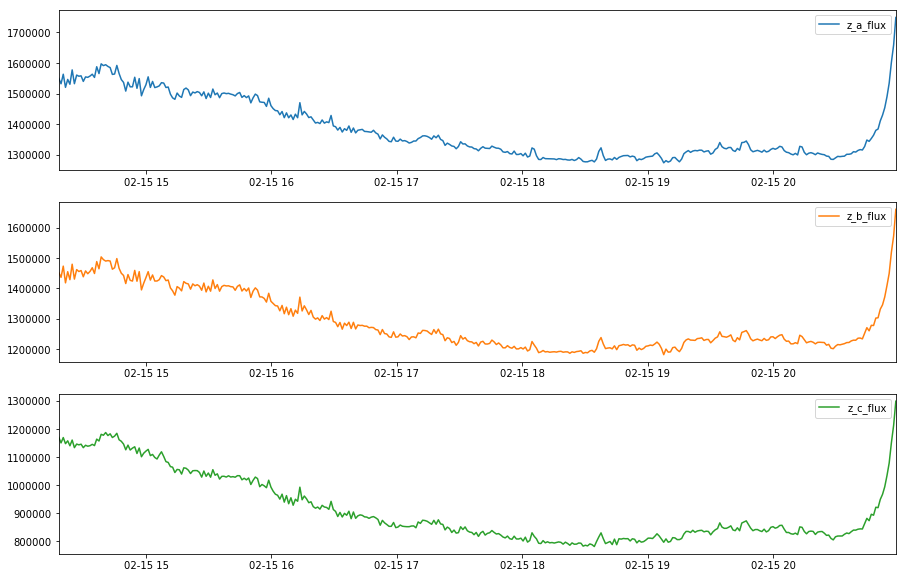

In [60]:
import pandas as pd
#import multiprocessing

box_size = 80

bands = [gband,rband,zband]
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
star_names = 'abc'

dfs = []

##loop in 3 stars given band  
dfs, band_idx =  make_lightcurve(band_idx=2)

#plot fluxes
df = plot_lightcurve(dfs, band_idx)

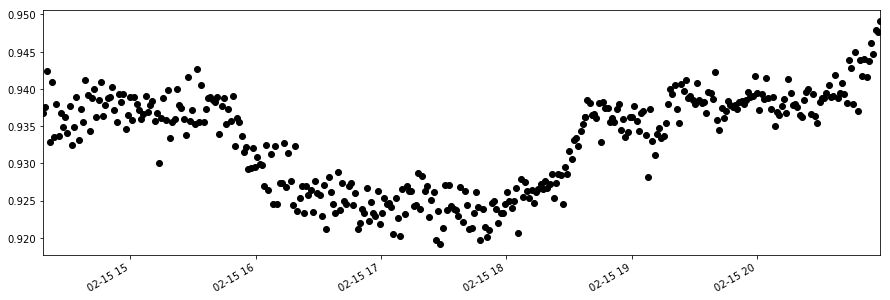

In [61]:
#differential photometry
res = df_phot(target='b', ref='a', showfig=True)

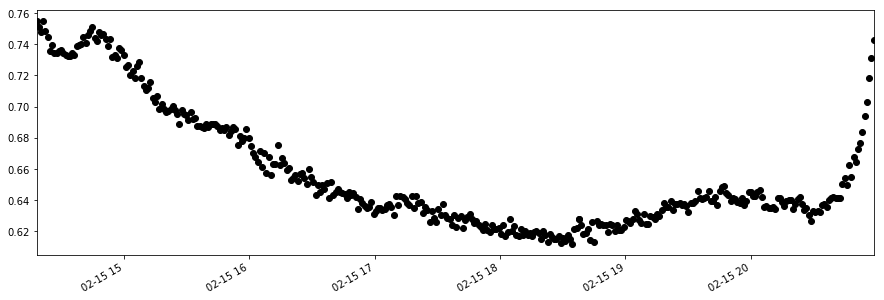

In [26]:
res = df_phot(target='c', ref='a', showfig=True)

## Analysis

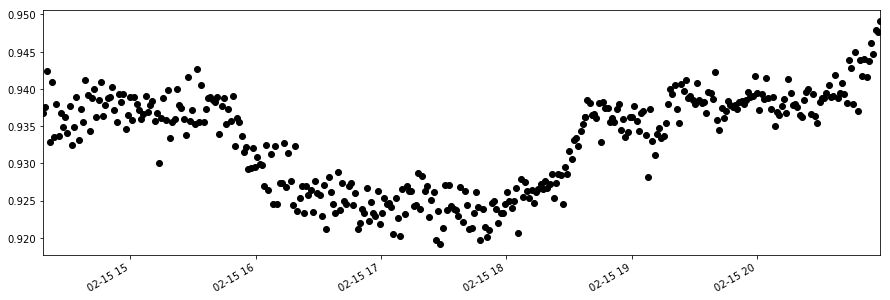

In [24]:
(df['z_b_flux'] / df['z_a_flux']).plot(figsize=(15,5), color='k', marker='o', linestyle='none')

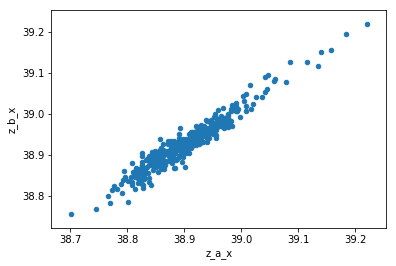

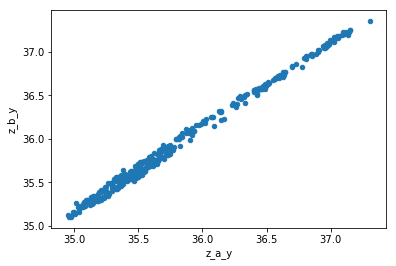

In [25]:
df.plot.scatter(*'z_a_x z_b_x'.split())
df.plot.scatter(*'z_a_y z_b_y'.split())

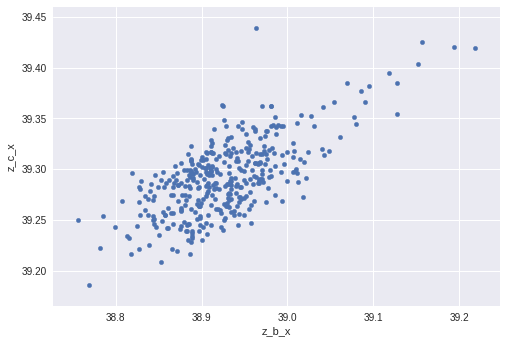

In [49]:
df.plot.scatter(*'z_b_x z_c_x'.split())

## Centroid

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3173d6c278>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3173cd91d0>], dtype=object)

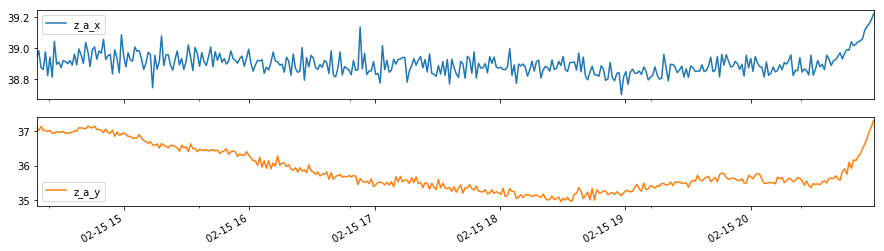

In [26]:
cols = 'z_a_x z_a_y'.split()
df[cols].plot(subplots=True, figsize=(15,4))

In [27]:
f = (df['z_b_flux'] / df['z_a_flux']).values
f /= np.median(f)

In [28]:
t = df.index.to_julian_date().values

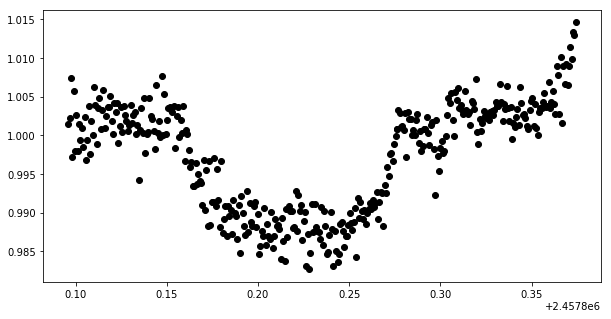

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(t, f, 'ko')

In [30]:
def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

tc = t.mean()
p = 4.3
k = np.sqrt(0.015)
i = np.pi/2
t14 = 2.8/24
u1 = 0.4
u2 = 0.4
a = scaled_a(p, t14, k, i=np.pi/2)
# ls = np.log(f.std())
# k0 = 0
# theta = [k,tc,a,i,u1,u2,ls,k0]
theta = [k,tc,a,i,u1,u2]
print ("initial guess: {}".format(theta))

initial guess: [0.1224744871391589, 2457800.2351597957, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]


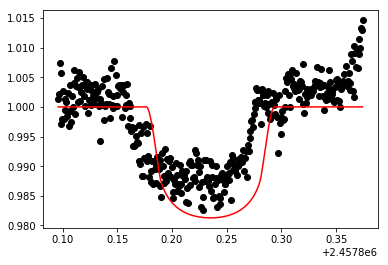

In [31]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-')

In [33]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print ("cost before: {}".format(obj(theta, t, p, f)))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')
print ("cost after: {}".format(obj(res.x, t, p, f)))

cost before: 0.013718065145897048
cost after: 0.007273391552866199


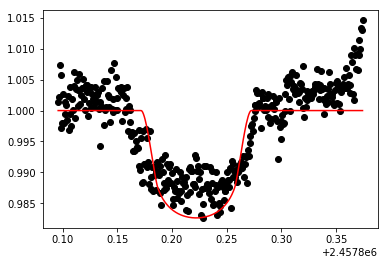

In [34]:
plt.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-')

In [35]:
ls = np.log(f.std())
k0 = 0
theta = [k,tc,a,i,u1,u2,ls,k0]

def loglike(theta, t, f, p, ret_mod=False):
    ls,k0 = theta[-2:]
    m = model_u(theta[:-2], t, p) + k0
    if ret_mod:
        return m
    resid = f - m
    inv_sig2 = np.exp(-2*ls)
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

nll = lambda *x: -loglike(*x)

print ("NLL before: {}".format(nll(theta, t, f, p)))
res = op.minimize(nll, theta, args=(t, p, f), method='powell')
print ("NLL after: {}".format(nll(res.x, t, f, p)))

NLL before: -1730.2527502507128
NLL after: 3.2733606027538275e+27


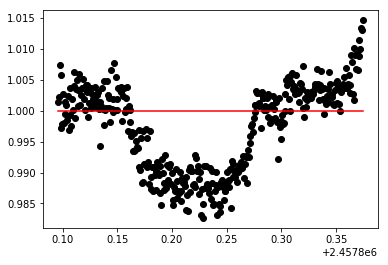

In [36]:
plt.plot(t, f, 'ko', t, model_u(res.x[:-2], t, p), 'r-')

In [37]:
def logprob(theta, t, f, p, up=None, ret_mod=False):

    if ret_mod:
        return loglike(theta, t, f, p, ret_mod=True)

    k,tc,a,i,u1,u2,ls,k0 = theta

    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf

    lp = 0
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    ll = loglike(theta, t, f, p)

    if np.isnan(ll).any():
        return -np.inf
    return lp + ll


nlp = lambda *x: -logprob(*x)

print ("NLP before: {}".format(nlp(theta, t, f, p)))
res = op.minimize(nlp, theta, args=(t, p, f), method='nelder-mead')
print ("NLP after: {}".format(nlp(res.x, t, f, p)))

NLP before: -1730.2527502507128
NLP after: 441.9617960285963


In [38]:
zip(theta, res.x)

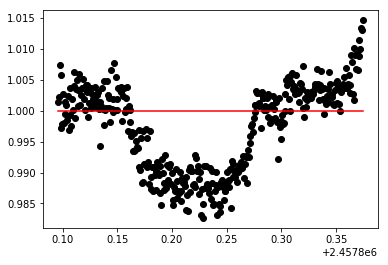

In [39]:
plt.plot(t, f, 'ko', t, model_u(res.x[:-2], t, p), 'r-')

In [40]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

0it [00:00, ?it/s]/home/jpdl/miniconda3/envs/astroconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/jpdl/miniconda3/envs/astroconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
1000it [00:27, 36.09it/s]


In [42]:
for i,j in zip(theta, sampler.flatchain.mean(axis=0)): 
    print(i,j)

0.122474487139 0.110726326177
2457800.23516 2457800.21944
13.18482235546915 11.5616168419
1.5707963267948966 1.54731466032
0.4 0.501279712905
0.4 0.242784806874
-4.95794607744 -5.740099718
0 0.00251412198954


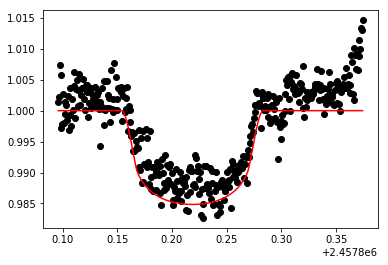

In [43]:
theta_new = np.median(sampler.flatchain, axis=0)

plt.plot(t, f, 'ko', t, model_u(theta_new[:-2], t, p), 'r-')

In [44]:
sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps1*5)):
    pass

5000it [02:05, 39.88it/s]


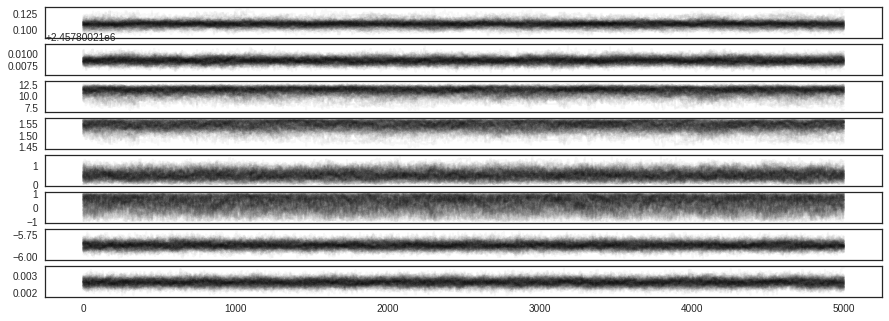

In [45]:
chain = sampler.chain
import seaborn as sb
with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]

In [46]:
ps = [logprob(th, t, f, p, ret_mod=True) for th in sampler.flatchain[np.random.randint(0, sampler.flatchain.shape[0], size=100)]]

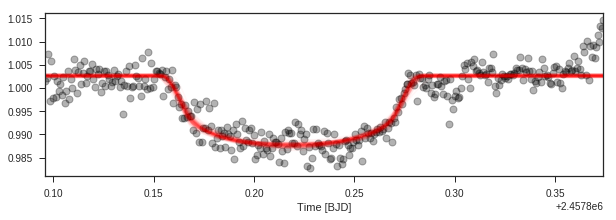

In [47]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        ax.plot(t, s, 'r-', alpha=0.03)
    plt.setp(ax, xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))

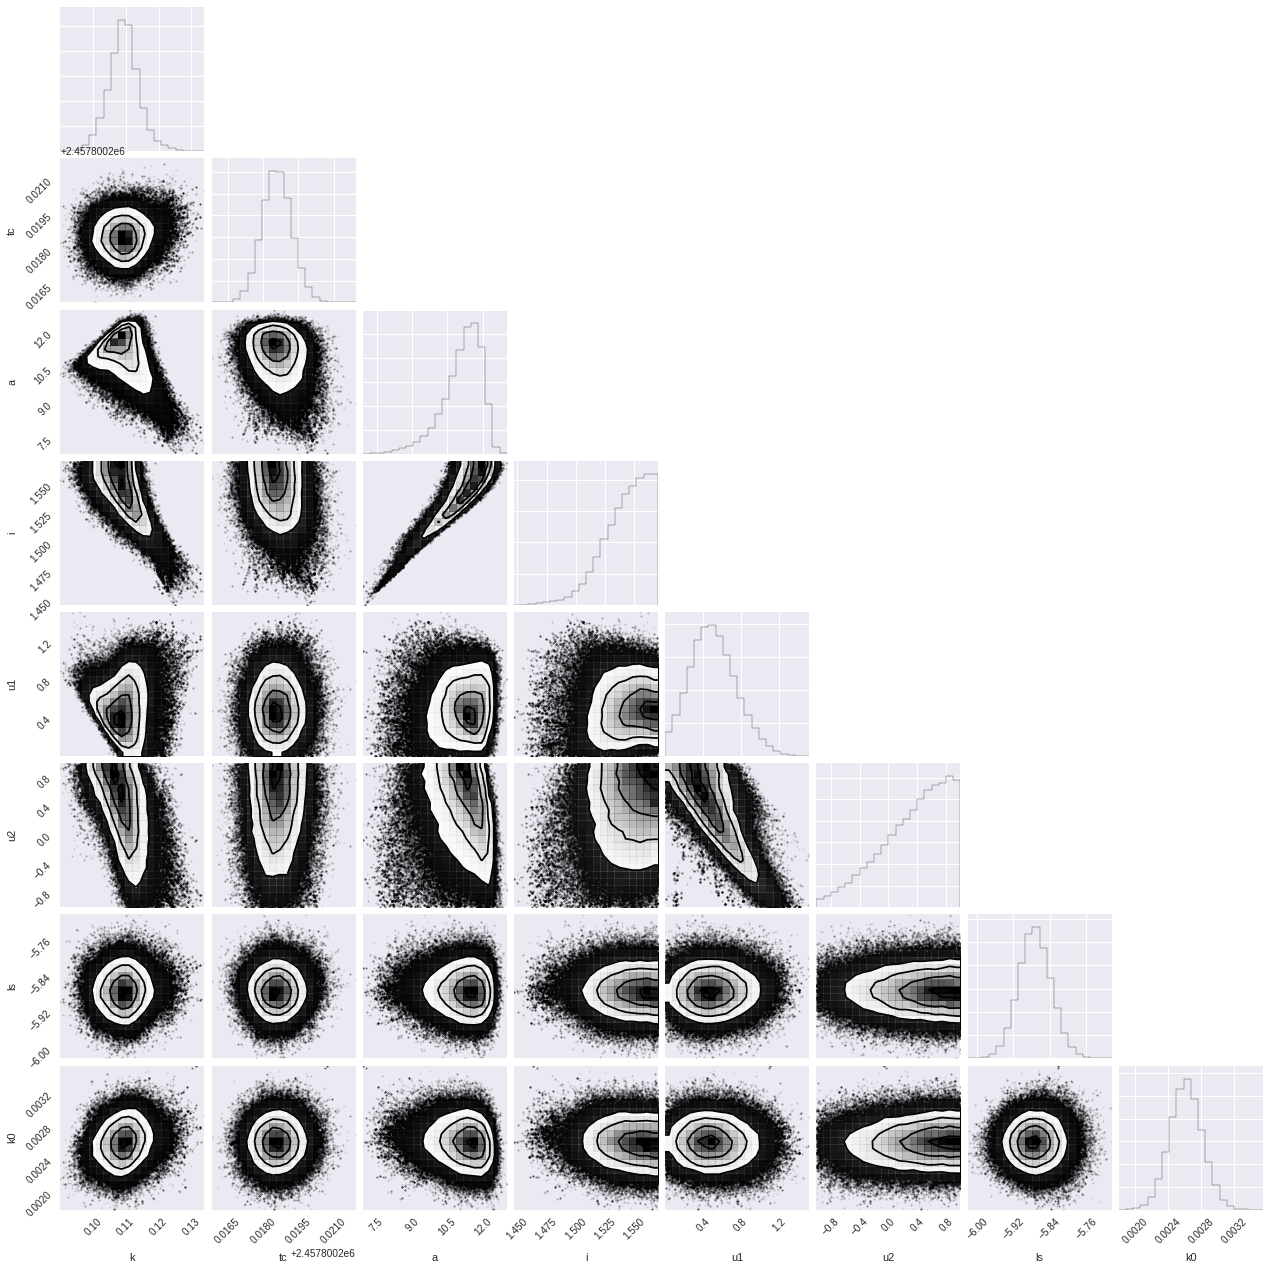

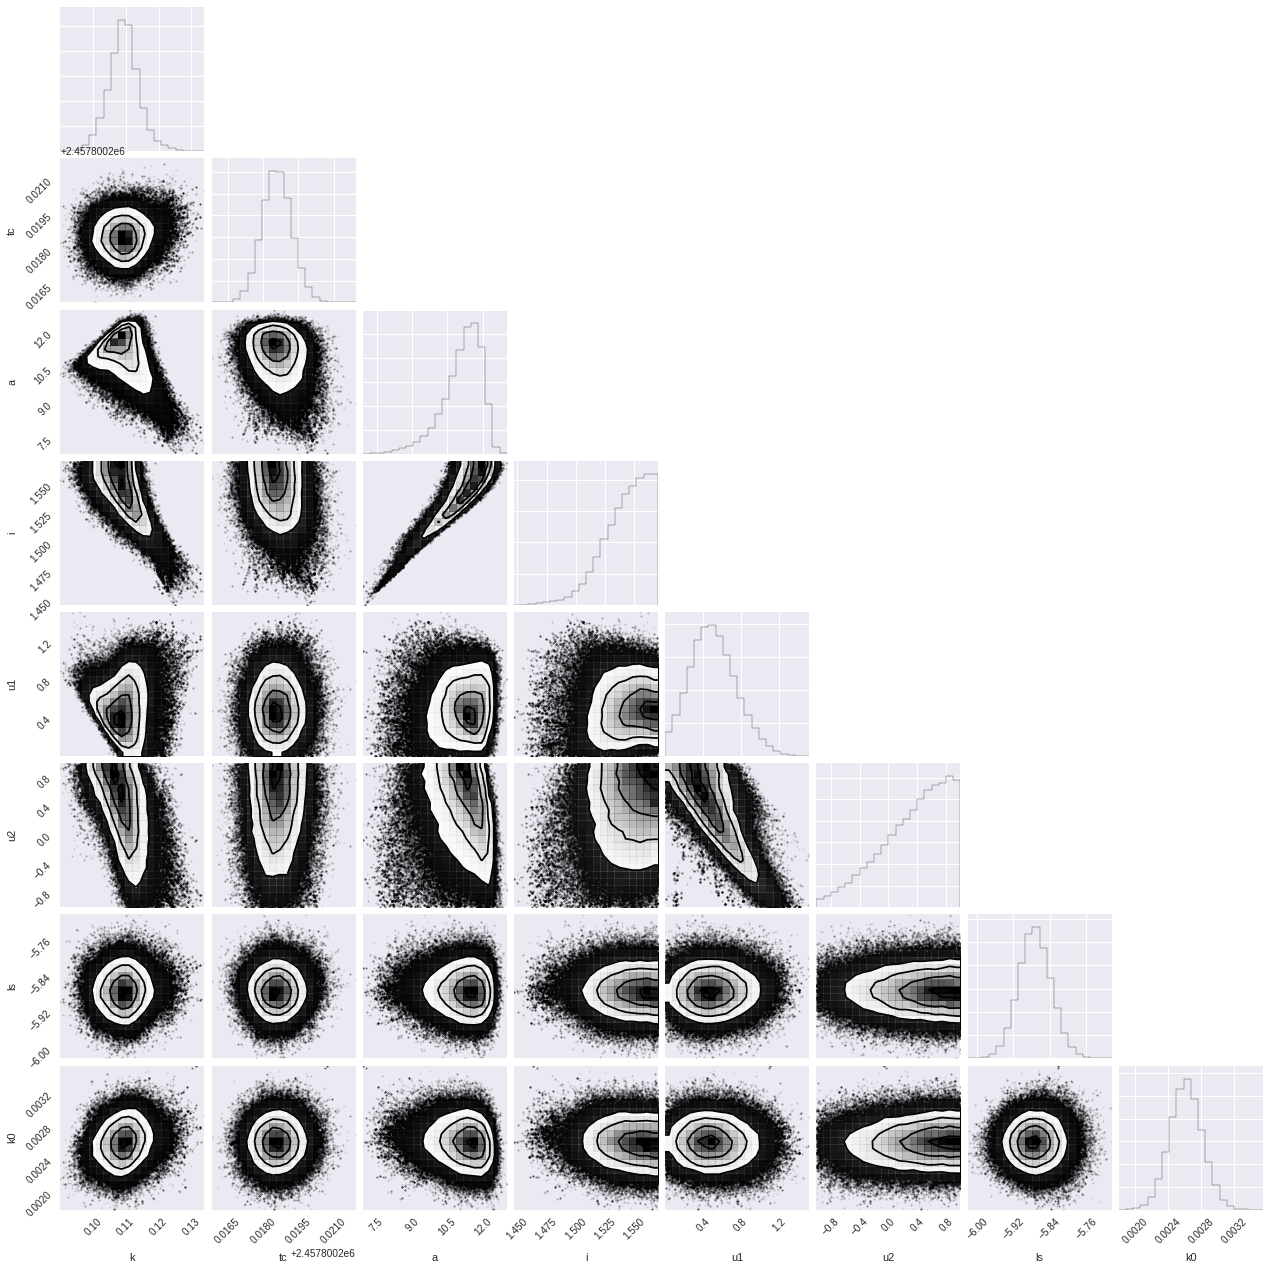

In [48]:
import corner
corner.corner(sampler.flatchain, labels='k,tc,a,i,u1,u2,ls,k0'.split(','))

100%|██████████| 704/704 [00:42<00:00, 16.68it/s]


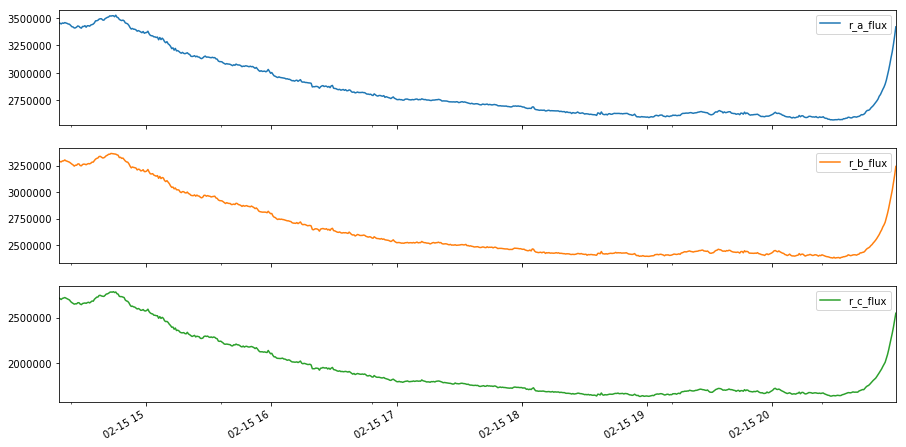

In [8]:
import pandas as pd
#import multiprocessing

box_size = 80

bands = [gband,rband,zband]
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
star_names = 'abc'

dfs = []

##loop in 3 bands
#for star_idx, band in enumerate(bands):   
dfs, band_idx =  make_lightcurve(band_idx=1)
df = plot_lightcurve(dfs, band_idx)

##loop in 3 stars (other star is for flux division later)

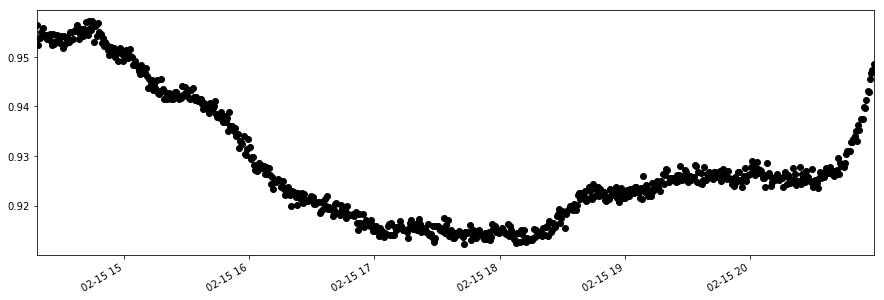

In [18]:
(df['r_b_flux'] / df['r_a_flux']).plot(figsize=(15,5), color='k', marker='o', linestyle='none')